# Linear regression

### Imports

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial

### Get data

In [7]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv'
!wget $data

--2025-10-13 23:47:36--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 874188 (854K) [text/plain]
Saving to: ‘car_fuel_efficiency.csv’

car_fuel_efficiency 100%[===================>] 853.70K  3.73MB/s    in 0.2s    

2025-10-13 23:47:36 (3.73 MB/s) - ‘car_fuel_efficiency.csv’ saved [874188/874188]



In [10]:
df = pd.read_csv('car_fuel_efficiency.csv')
df

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369
...,...,...,...,...,...,...,...,...,...,...,...
9699,140,5.0,164.0,2981.107371,17.3,2013,Europe,Diesel,Front-wheel drive,NaN,15.101802
9700,180,NaN,154.0,2439.525729,15.0,2004,USA,Gasoline,All-wheel drive,0.0,17.962326
9701,220,2.0,138.0,2583.471318,15.1,2008,USA,Diesel,All-wheel drive,-1.0,17.186587
9702,230,4.0,177.0,2905.527390,19.4,2011,USA,Diesel,Front-wheel drive,1.0,15.331551


### Data preparation

In [12]:
columns = [
    'engine_displacement', 'horsepower', 'vehicle_weight',
    'model_year', 'fuel_efficiency_mpg',
]
df = df[columns]
df

,engine_displacement,horsepower,vehicle_weight,model_year,fuel_efficiency_mpg
0,170,159.0,3413.433759,2003,13.231729
1,130,97.0,3149.664934,2007,13.688217
2,170,78.0,3079.038997,2018,14.246341
3,220,NaN,2542.392402,2009,16.912736
4,210,140.0,3460.870990,2009,12.488369
...,...,...,...,...,...
9699,140,164.0,2981.107371,2013,15.101802
9700,180,154.0,2439.525729,2004,17.962326
9701,220,138.0,2583.471318,2008,17.186587
9702,230,177.0,2905.527390,2011,15.331551


### EDA

In [14]:
df.describe()

,engine_displacement,horsepower,vehicle_weight,model_year,fuel_efficiency_mpg
count,9704.000000,8996.000000,9704.000000,9704.000000,9704.000000
mean,199.708368,149.657292,3001.280993,2011.484027,14.985243
std,49.455319,29.879555,497.894860,6.659808,2.556468
min,10.000000,37.000000,952.681761,2000.000000,6.200971
25%,170.000000,130.000000,2666.248985,2006.000000,13.267459
50%,200.000000,149.000000,2993.226296,2012.000000,15.006037
75%,230.000000,170.000000,3334.957039,2017.000000,16.707965
max,380.000000,271.000000,4739.077089,2023.000000,25.967222


<Axes: xlabel='fuel_efficiency_mpg', ylabel='Count'>

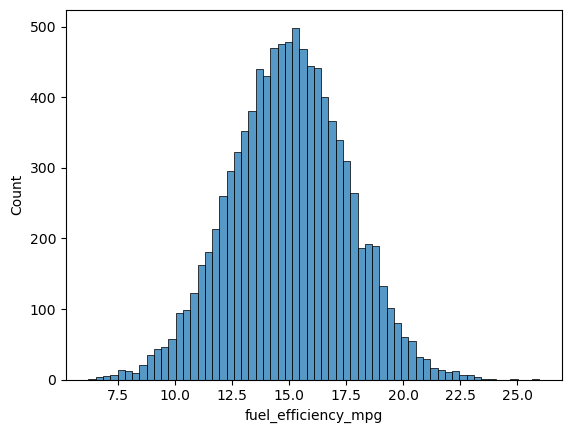

In [17]:
sns.histplot(df.fuel_efficiency_mpg)

### Setting up the validation framework

In [48]:
def divide_df(df, seed, percent_val=0.2, percent_test=0.2):
    n = len(df)
    n_val = int(n*percent_val)
    n_test = int(n*percent_test)
    n_train = n - n_val - n_test

    idx = np.arange(n)
    np.random.seed(seed)
    np.random.shuffle(idx)

    df_train = df.iloc[idx[:n_train]]
    df_val = df.iloc[idx[n_train:n_train+n_val]]
    df_test = df.iloc[idx[n_train+n_val:]]

    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    y_train = df_train.fuel_efficiency_mpg.values
    y_val = df_val.fuel_efficiency_mpg.values
    y_test = df_test.fuel_efficiency_mpg.values

    del df_train['fuel_efficiency_mpg']
    del df_val['fuel_efficiency_mpg']
    del df_test['fuel_efficiency_mpg']

    return df_train, df_val, df_test, y_train, y_val, y_test

In [50]:
df_train, df_val, df_test, y_train, y_val, y_test = divide_df(df, 42)
print(len(df_train), len(df_val), len(df_test), len(y_train), len(y_val), len(y_test))

5824 1940 1940 5824 1940 1940


### Training a linear regression model

In [40]:
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    return w_full[0], w_full[1:]

In [41]:
def rmse(y, y_pred):
    squared_error = (y - y_pred) ** 2
    mean_suqared_error = squared_error.mean()
    return np.sqrt(mean_suqared_error)

In [57]:
def validate_model(df_train, y_train, df_test, y_test, prepare_X, r=0.0):
    X_train = prepare_X(df_train)
    w0, w = train_linear_regression_reg(X_train, y_train, r)
    X_test = prepare_X(df_test)
    y_pred = w0 + X_test.dot(w)
    return rmse(y_test, y_pred)

In [45]:
features = [
    'engine_displacement',
    'horsepower',
    'vehicle_weight',
    'model_year',
]

def prepare_X(filler, df):
    df_num = df.copy()
    df_num = df_num[features]
    df_num = df_num.fillna(filler)
    X = df_num.values
    return X

prepare_X_fill_0 = partial(prepare_X, 0)

horsepower_mean = df_train.horsepower.mean()
prepare_X_fill_mean = partial(prepare_X, horsepower_mean)

np.float64(149.54476367006487)

# Answers on questions

### Question 1
There's one column with missing values. What is it?

* 'engine_displacement'
* 'horsepower'
* 'vehicle_weight'
* 'model_year'

In [19]:
df.isnull().sum()

engine_displacement      0
horsepower             708
vehicle_weight           0
model_year               0
fuel_efficiency_mpg      0
dtype: int64

**Answer:** horsepower

### Question 2
What's the median (50% percentile) for variable 'horsepower'?

* 49
* 99
* 149
* 199

In [20]:
df.horsepower.median()

149.0

**Answer**: 149

### Question 3
* We need to deal with missing values for the column from Q1.
* We have two options: fill it with 0 or with the mean of this variable.
* Try both options. For each, train a linear regression model without regularization using the code from the lessons.
* For computing the mean, use the training only!
* Use the validation dataset to evaluate the models and compare the RMSE of each option.
* Round the RMSE scores to 2 decimal digits using round(score, 2)
* Which option gives better RMSE?

Options:
* With 0
* With mean
* Both are equally good

In [43]:
round(validate_model(df_train, y_train, df_val, y_val, prepare_X_fill_0), 2)

np.float64(0.52)

In [46]:
round(validate_model(df_train, y_train, df_val, y_val, prepare_X_fill_mean), 2)

np.float64(0.46)

**Answer**: With mean is better

### Question 4
* Now let's train a regularized linear regression.
* For this question, fill the NAs with 0.
* Try different values of r from this list: [0, 0.01, 0.1, 1, 5, 10, 100].
* Use RMSE to evaluate the model on the validation dataset.
* Round the RMSE scores to 2 decimal digits.
* Which r gives the best RMSE?
* If multiple options give the same best RMSE, select the smallest r.

Options:

* 0
* 0.01
* 1
* 10
* 100

In [47]:
for r in [0, 0.01, 0.1, 1, 5, 10, 100]:
    score = validate_model(df_train, y_train, df_val, y_val, prepare_X_fill_0, r)
    print(r, round(score, 2))

0 0.52
0.01 0.52
0.1 0.52
1 0.52
5 0.52
10 0.52
100 0.52


### Question 5 

* We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
* Try different seed values: `[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]`.
* For each seed, do the train/validation/test split with 60%/20%/20% distribution.
* Fill the missing values with 0 and train a model without regularization.
* For each seed, evaluate the model on the validation dataset and collect the RMSE scores. 
* What's the standard deviation of all the scores? To compute the standard deviation, use `np.std`.
* Round the result to 3 decimal digits (`round(std, 3)`)

What's the value of std?

- 0.001
- 0.006
- 0.060
- 0.600

In [58]:
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
scores = []
for seed in seeds:
    df_train_seed, df_val_seed, _, y_train_seed, y_val_seed, _ = divide_df(df, seed)
    score = validate_model(df_train_seed, y_train_seed, df_val_seed, y_val_seed, prepare_X_fill_0)
    scores.append(score)

print(round(np.std(scores), 3))

0.007


**Answer**: 0.006

### Question 6

* Split the dataset like previously, use seed 9.
* Combine train and validation datasets.
* Fill the missing values with 0 and train a model with `r=0.001`. 
* What's the RMSE on the test dataset?

Options:

- 0.15
- 0.515
- 5.15
- 51.5

In [66]:
df_train_seed, df_val_seed, df_test_seed, y_train_seed, y_val_seed, y_test_seed = divide_df(df, 9)
df_train_seed = pd.concat([df_train_seed, df_val_seed])
y_train_seed = np.concatenate([y_train_seed, y_val_seed])

In [67]:
validate_model(df_train_seed, y_train_seed, df_test_seed, y_test_seed, prepare_X_fill_0, 0.001)

np.float64(0.5156261299185212)

**Answer**: 0.515